# Asset Management – WS25/26 – Assignment

**Student ID:** 244604  
**Student Name:** *Sakila Akter Tania*  

This notebook implements:

1. Download of daily prices for the 5 assigned stocks and IBEX.
2. Computation of monthly returns.
3. Loading and cleaning of Fama–French European 3 factors.
4. CAPM regression for each stock vs IBEX (excess returns).
5. Fama French 3-factor regression for each stock.
6. Price development plot.
7. Jointplots of stock vs index monthly returns.


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime, timedelta
import os

In [3]:
sns.set()

# 1. SETTINGS


In [4]:
stocks = ["BKT.MC", "ENG.MC", "ANA.MC", "COL.MC", "LOG.MC"]
index_ticker = "^IBEX"

In [5]:
end_date = datetime.today()
start_date = end_date - timedelta(days=5*365)

# Create folders

In [6]:
os.makedirs("figures", exist_ok=True)
os.makedirs("outputs", exist_ok=True)

# 2. DOWNLOAD PRICE DATA

In [7]:
all_tickers = stocks + [index_ticker]

data = yf.download(
    tickers=all_tickers,
    start=start_date,
    end=end_date,
    auto_adjust=True
)

prices = data["Close"].dropna()
print("Prices downloaded.\n")
prices.tail()

[*********************100%***********************]  6 of 6 completed

Prices downloaded.



Ticker,ANA.MC,BKT.MC,COL.MC,ENG.MC,LOG.MC,^IBEX
Date,,,,,,
2025-12-03,170.800003,13.820,5.225,14.000,29.639999,16585.699219
2025-12-04,175.000000,13.650,5.245,13.990,29.400000,16746.599609
2025-12-05,174.100006,13.655,5.225,13.900,28.500000,16688.500000
2025-12-08,176.699997,13.750,5.125,13.975,28.320000,16712.199219
2025-12-09,176.600006,13.860,5.120,13.825,28.540001,16734.500000


# 3. MONTHLY RETURNS (ALIGN TO MONTH START)

In [8]:
print("Converting to monthly returns...")

monthly_prices = prices.resample("M").last()
monthly_returns = monthly_prices.pct_change().dropna()

Converting to monthly returns...


C:\Users\Sadib\AppData\Local\Temp\ipykernel_28936\2158181507.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_prices = prices.resample("M").last()


# Convert month-end → month-start

In [9]:
monthly_returns.index = monthly_returns.index.to_period("M").to_timestamp()

print("Monthly returns generated.\n")
monthly_returns.head()

Monthly returns generated.



Ticker,ANA.MC,BKT.MC,COL.MC,ENG.MC,LOG.MC,^IBEX
Date,,,,,,
2021-01-01,0.059983,0.050181,-0.009346,0.011689,-0.020176,-0.039164
2021-02-01,0.078415,0.197150,0.016352,-0.044567,0.081884,0.060264
2021-03-01,0.071214,0.077931,0.021658,0.066513,0.054931,0.043161
2021-04-01,0.012596,0.068947,0.021805,-0.021598,0.023669,0.027389
2021-05-01,-0.045612,0.029186,0.081209,0.060982,0.035838,0.037879


# 4. LOAD & CLEAN FAMA-FRENCH EUROPE FACTORS

In [11]:
ff = pd.read_csv("data/Europe_3_Factors.csv", skiprows=6)
ff.head()

,Unnamed: 0,Mkt-RF,SMB,HML,RF
0,199007,4.46,0.29,-1.52,0.68
1,199008,-10.88,0.18,-0.30,0.66
2,199009,-12.19,1.98,0.44,0.60
3,199010,6.45,-2.63,-1.12,0.68
4,199011,-0.42,-2.60,0.57,0.57


In [12]:
ff.rename(columns={ff.columns[0]: "Date"}, inplace=True)
ff["Date"] = ff["Date"].astype(str).str.strip()

In [ ]:
# Keep only YYYYMM rows
ff = ff[ff["Date"].str.match(r'^\d{6}$')]
ff["Date"] = pd.to_datetime(ff["Date"], format="%Y%m")

In [14]:
# Convert FF dates to month-start
ff.index = ff["Date"].dt.to_period("M").dt.to_timestamp()
ff = ff.drop(columns=["Date"])

In [15]:
# Keep only factor columns
ff = ff[["Mkt-RF", "SMB", "HML", "RF"]]

In [16]:
# Convert numeric
for col in ff.columns:
    ff[col] = pd.to_numeric(ff[col], errors="coerce")

ff = ff.dropna()
ff = ff / 100.0   # percent → decimal

print("FF dates:", ff.index.min(), "→", ff.index.max(), "\n")
ff.head()

FF dates: 1990-07-01 00:00:00 → 2025-10-01 00:00:00 



,Mkt-RF,SMB,HML,RF
Date,,,,
1990-07-01,0.0446,0.0029,-0.0152,0.0068
1990-08-01,-0.1088,0.0018,-0.0030,0.0066
1990-09-01,-0.1219,0.0198,0.0044,0.0060
1990-10-01,0.0645,-0.0263,-0.0112,0.0068
1990-11-01,-0.0042,-0.0260,0.0057,0.0057


# 5. CREATE STOCK + INDEX RETURNS BEFORE MERGING

In [17]:
stock_returns = monthly_returns[stocks]
index_returns = monthly_returns[index_ticker]

In [18]:
# Align to FF date range
stock_returns = stock_returns.loc[ff.index.min(): ff.index.max()]
index_returns = index_returns.loc[ff.index.min(): ff.index.max()]

In [19]:
print("Stock returns shape:", stock_returns.shape)
print("Index returns shape:", index_returns.shape, "\n")

Stock returns shape: (58, 5)
Index returns shape: (58,) 



# 6. MERGE RETURNS + FACTORS

In [20]:
data_merged = pd.concat(
    [stock_returns, index_returns.rename("IBEX"), ff],
    axis=1
).dropna()

print("Data merged:", data_merged.shape, "\n")

Data merged: (58, 10) 



In [21]:
# Compute excess returns (stock and index minus RF)
excess_stock_returns = data_merged[stocks].sub(data_merged["RF"], axis=0)
excess_ibex = data_merged["IBEX"] - data_merged["RF"]
SMB = data_merged["SMB"]
HML = data_merged["HML"]

data_merged.head()

,BKT.MC,ENG.MC,ANA.MC,COL.MC,LOG.MC,IBEX,Mkt-RF,SMB,HML,RF
Date,,,,,,,,,,
2021-01-01,0.050181,0.011689,0.059983,-0.009346,-0.020176,-0.039164,-0.0125,0.0166,-0.0029,0.0
2021-02-01,0.197150,-0.044567,0.078415,0.016352,0.081884,0.060264,0.0260,0.0087,0.0573,0.0
2021-03-01,0.077931,0.066513,0.071214,0.021658,0.054931,0.043161,0.0318,-0.0197,0.0346,0.0
2021-04-01,0.068947,-0.021598,0.012596,0.021805,0.023669,0.027389,0.0529,0.0214,-0.0319,0.0
2021-05-01,0.029186,0.060982,-0.045612,0.081209,0.035838,0.037879,0.0452,-0.0099,0.0206,0.0


# 7. FILTER ONLY VALID STOCKS

In [22]:
valid_stocks = [s for s in stocks if not excess_stock_returns[s].dropna().empty]
print("Valid stocks:", valid_stocks, "\n")

excess_stock_returns = excess_stock_returns[valid_stocks]
stock_returns = stock_returns[valid_stocks]

Valid stocks: ['BKT.MC', 'ENG.MC', 'ANA.MC', 'COL.MC', 'LOG.MC'] 



# 8. CAPM REGRESSION

In [25]:
print("Running CAPM regressions...")
capm_results = []

for s in valid_stocks:
    y = excess_stock_returns[s]

    # Create X with constant and IBEX excess return
    X = pd.DataFrame({
        "const": 1,
        "IBEX": excess_ibex
    })

    model = sm.OLS(y, X).fit()

    capm_results.append({
        "Stock": s,
        "Alpha": model.params["const"],
        "Beta_IBEX": model.params["IBEX"],
        "Alpha_t": model.tvalues["const"],
        "Beta_t": model.tvalues["IBEX"],
        "R2": model.rsquared
    })

Running CAPM regressions...


In [26]:
capm_df = pd.DataFrame(capm_results)
print(capm_df)
capm_df.to_excel("outputs/CAPM_results_244604.xlsx", index=False)
print("\nCAPM results saved to outputs/CAPM_results_244604.xlsx")

    Stock     Alpha  Beta_IBEX   Alpha_t    Beta_t        R2
0  BKT.MC  0.022894   0.668497  2.424179  3.075604  0.144507
1  ENG.MC -0.003827   0.426367 -0.673693  3.261540  0.159634
2  ANA.MC  0.003108   0.835200  0.340583  3.976510  0.220193
3  COL.MC -0.015090   1.223245 -1.959126  6.900055  0.459516
4  LOG.MC  0.010312   0.432067  1.890131  3.441024  0.174536

CAPM results saved to outputs/CAPM_results_244604.xlsx


# 9. FAMA-FRENCH 3-FACTOR REGRESSION

In [27]:
print("Running Fama-French regressions...")
ff_results = []

for s in valid_stocks:
    y = excess_stock_returns[s]

    X = pd.concat([
        excess_ibex.rename("EX_IBEX"),
        SMB.rename("SMB"),
        HML.rename("HML")
    ], axis=1)

    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()

    ff_results.append({
        "Stock": s,
        "Alpha": model.params["const"],
        "Beta_IBEX": model.params["EX_IBEX"],
        "SMB_coef": model.params["SMB"],
        "HML_coef": model.params["HML"],
        "R2": model.rsquared
    })

Running Fama-French regressions...


In [28]:
ff_df = pd.DataFrame(ff_results)
print(ff_df)
ff_df.to_excel("outputs/FF3_results_244604.xlsx", index=False)
print("\nFama-French results saved to outputs/FF3_results_244604.xlsx")

    Stock     Alpha  Beta_IBEX  SMB_coef  HML_coef        R2
0  BKT.MC  0.010834   0.466079  0.364525  1.547537  0.495006
1  ENG.MC -0.001257   0.465452  0.004445 -0.285513  0.192572
2  ANA.MC  0.013091   0.932127  1.134136 -0.508346  0.332566
3  COL.MC -0.004761   1.297994  1.692860 -0.246548  0.613377
4  LOG.MC  0.010662   0.437487 -0.001421 -0.039958  0.175218

Fama-French results saved to outputs/FF3_results_244604.xlsx


# 10. PRICE DEVELOPMENT PLOT

Generating price plot...


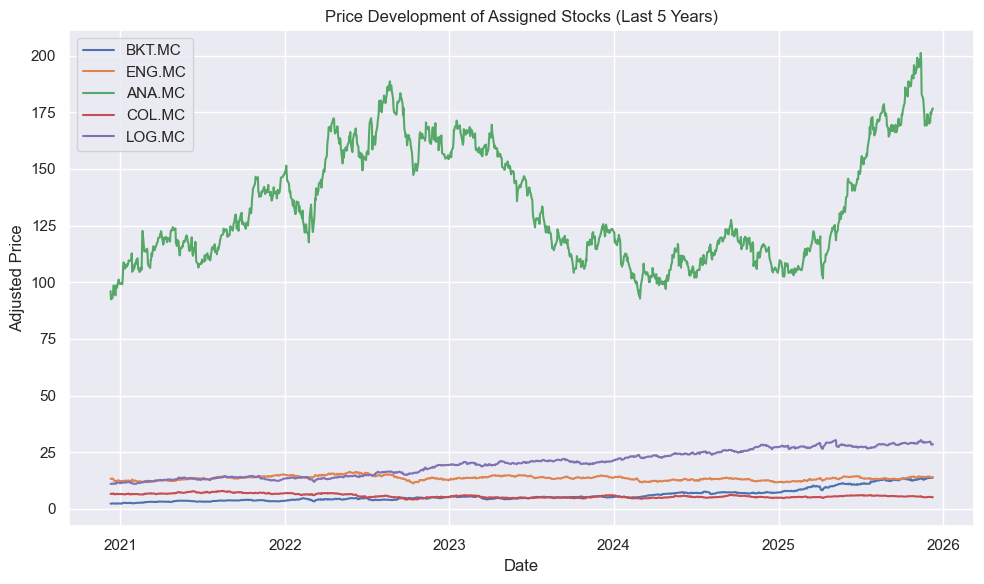

Price plot saved to figures/price_development_244604.png


In [29]:
print("Generating price plot...")
plt.figure(figsize=(10, 6))

for s in valid_stocks:
    plt.plot(prices.index, prices[s], label=s)

plt.title("Price Development of Assigned Stocks (Last 5 Years)")
plt.xlabel("Date")
plt.ylabel("Adjusted Price")
plt.legend()
plt.tight_layout()
plt.savefig("figures/price_development_244604.png", dpi=300)
plt.show()

print("Price plot saved to figures/price_development_244604.png")

# 11. JOINTPLOTS

In [30]:
print("Generating jointplots...")
for s in valid_stocks:
    tmp = pd.DataFrame({
        s: stock_returns[s],
        "IBEX": index_returns
    }).dropna()

    g = sns.jointplot(
        data=tmp,
        x="IBEX",
        y=s,
        kind="reg"
    )

    g.fig.suptitle(f"Jointplot of {s} vs IBEX Monthly Returns")
    g.fig.tight_layout()
    g.fig.subplots_adjust(top=0.95)

    filename = f"figures/jointplot_{s}_244604.png"
    g.fig.savefig(filename, dpi=300)
    plt.close(g.fig)
    print(f"Saved {filename}")

print("\nAll jointplots saved.\n")
print("Assignment completed successfully!")

Generating jointplots...
Saved figures/jointplot_BKT.MC_244604.png
Saved figures/jointplot_ENG.MC_244604.png
Saved figures/jointplot_ANA.MC_244604.png
Saved figures/jointplot_COL.MC_244604.png
Saved figures/jointplot_LOG.MC_244604.png

All jointplots saved.

Assignment completed successfully!
